<a href="https://colab.research.google.com/github/kumarseshu123/VCC/blob/main/vgg_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
from scipy.stats import pearsonr



################ HELPER FUNCTIONS ###############################
#Calculate the variance of the output per batch
def batch_entropy(outputs):
  # Find the number of classes in this distribution 
  num_classes = outputs.shape[1]
  num_examples = outputs.shape[0]

  # Find the total probablity of each class
  sum_prob = tf.math.reduce_sum(outputs, axis=0)
  sum_prob = sum_prob/(num_examples)

  # Find the log of each probablity 

  # Shannon probablity is  Sum (-( p(x)) * log (p(x)))

  #return (tf.math.reduce_variance(outputs, axis=0))


# Calculate the variance of the output per batch
def batch_variance(outputs):
  return (tf.math.reduce_variance(outputs, axis=0))


################ BASE MODEL ###################################
# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert the labels to categorical data
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Define a VGG model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train_cat, epochs=10, batch_size=128)
print(model.summary())

################ COLLECT STATS ABOUT THE MODEL ##################
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

# Plot the batch variance
batch_variances_tensor = np.zeros((2000,10),dtype=float)
hidden_variances_tensor = np.zeros((2000,64), dtype=float)
batch_output_entropy = []

batch_idx_index = 0
for batch_idx in range(0, (len(x_train)), 25):
  outputs = model(x_train[batch_idx:batch_idx+25])
  first_conv_layer_output = extractor(x_train[batch_idx:batch_idx+25])

  # for each batch, we need to find the variance per node
  # Get the max value per channel per example 
  max_output_layer_4 = tf.math.reduce_max(first_conv_layer_output[4], axis=1)
  max_output_layer_4 = tf.math.reduce_max(max_output_layer_4, axis=1)
  hidden_variances_tensor[batch_idx_index] = batch_variance(max_output_layer_4)
  batch_variances_tensor[batch_idx_index]  = batch_variance(outputs)
  batch_idx_index= batch_idx_index + 1

print("CACL ENTROPY")
batch_entropy(y_train_cat[0:25])

print("Shapes of the first node")
print(hidden_variances_tensor.shape)
print(batch_variances_tensor.shape)


hidden_correlation = np.zeros(hidden_variances_tensor.shape[1])
for hidden_node in range(0, hidden_variances_tensor.shape[1]):
  hidden_correlation[hidden_node] = 0
  for output_node in range(0, batch_variances_tensor.shape[1]):
    corr, p_value = pearsonr( hidden_variances_tensor[: ,hidden_node]  ,  batch_variances_tensor[: ,output_node])
    if(corr > hidden_correlation[hidden_node]):
      hidden_correlation[hidden_node] = abs(corr)



ModelLoss, ModelAccuracy = model.evaluate(x_train, y_train_cat)
print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))
print('Print model size and other info')
print(model.summary())



################ PRUNE THE MODEL ###############################
from random import randint

# Remove all nodes that have low covariance
for hidden_node in range(0, hidden_variances_tensor.shape[1]):
  #if(hidden_correlation[hidden_node] < 0.1):
  if( hidden_node % 5  ==0):
      print("Setting weight to zero")
      layer = model.layers[4]
      W_matrix = layer.weights[0]
      b_list = layer.weights[1]

      # Set the weights of the W matrix as 0 
      mask_b = np.ones(b_list.shape)
      mask_b[hidden_node] = 0
      mask_b_tensor  = tf.convert_to_tensor(mask_b, dtype=float)
      new_b_list     = tf.math.multiply(mask_b_tensor, b_list)

      # Set the bias term as 0
      mask = np.ones(W_matrix.shape)
      mask[:,:,:,hidden_node] = 0
      mask_tensor  = tf.convert_to_tensor(mask, dtype=float)
      new_W_matrix = tf.math.multiply(mask_tensor, W_matrix)

      # Assign new weights to the model 
      new_weights = [new_W_matrix, new_b_list]
      model.layers[4].set_weights(new_weights)



################ COLLECT ACCURACY AFTER PRUNING ################## 
ModelLoss, ModelAccuracy = model.evaluate(x_train, y_train_cat)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))
print('Print model size and other info')
print(model.summary())
                                        


Epoch 1/10
391/391 [==============================] - 6s 11ms/step - loss: 1.4783 - accuracy: 0.4652
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 1.0250 - accuracy: 0.6378
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.8355 - accuracy: 0.7088
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 0.7160 - accuracy: 0.7493
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6210 - accuracy: 0.7835
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5419 - accuracy: 0.8102
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4618 - accuracy: 0.8384
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss: 0.3896 - accuracy: 0.8643
Epoch 9/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3209 - accuracy: 0.8871
Epoch 10/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2672 - accura

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        369

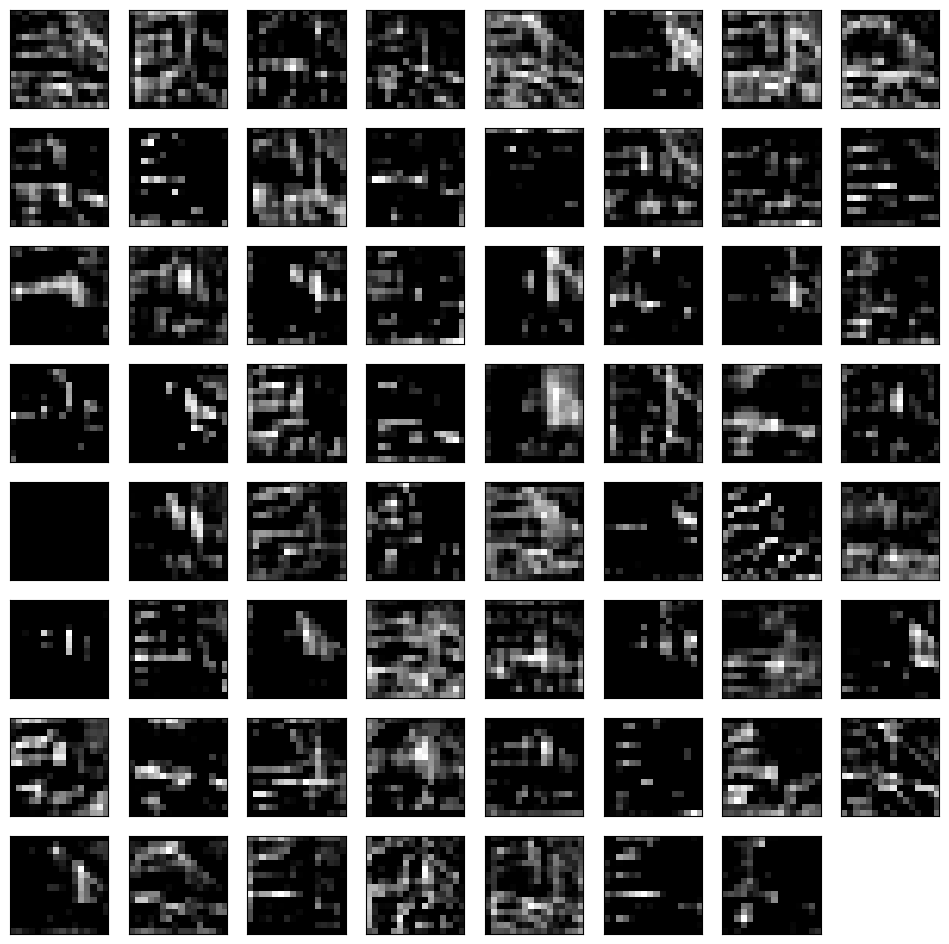

THIS IS ONE 


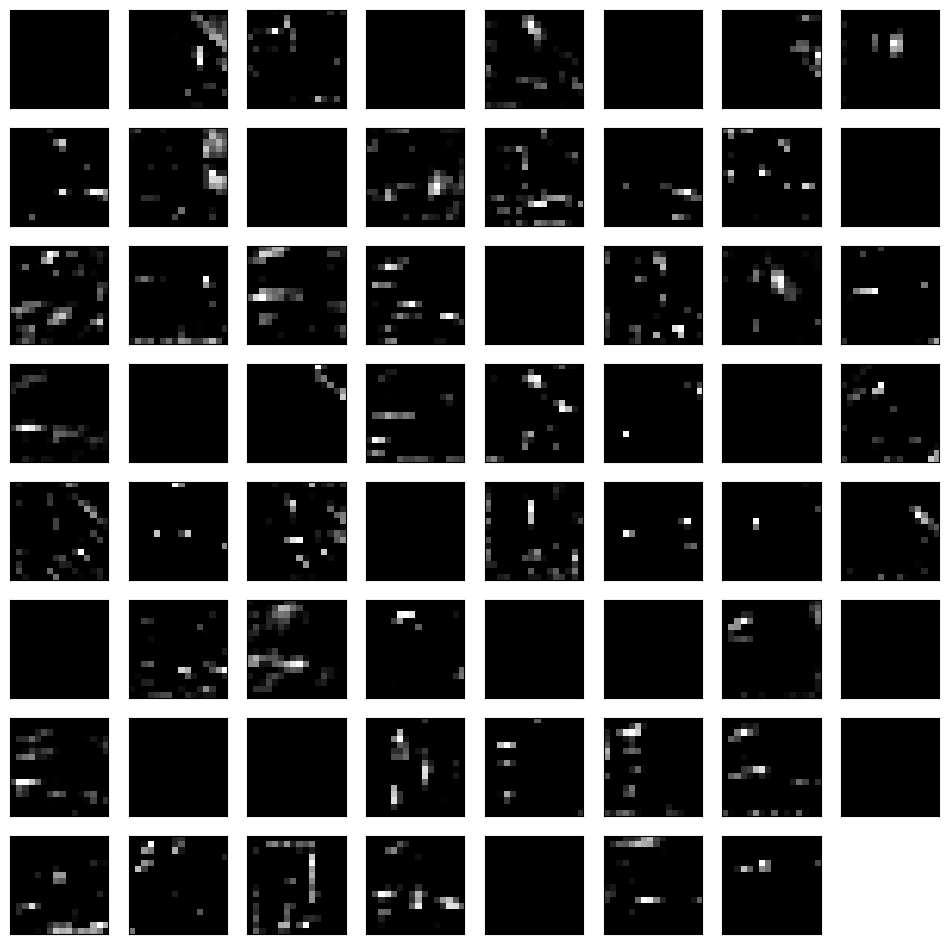

In [73]:
conv_layer_index = [3, 4]
outputs= [model.layers[i].output for i in conv_layer_index]
model_short = keras.Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

input_im = np.expand_dims(x_train[1], axis=0)

print(input_im.shape)

y_out = model_short.predict(input_im)

columns=8
rows=8
n_filters = columns*rows

for ftr in (y_out):
  print("THIS IS ONE ")

  fig=plt.figure(figsize=(12,12))
  for i in range (1, n_filters):
    fig = plt.subplot(rows,columns,i)
    fig.set_xticks([])
    fig.set_yticks([])
    plt.imshow(ftr[0, :,:,i-1], cmap='gray')
  plt.show()


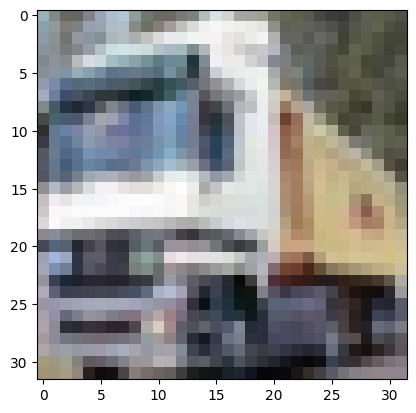

(50000, 32, 32, 3)
[9]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [44]:
# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255

y = x_train[1]
plt.imshow(y)
plt.show()

print(x_train.shape)
print(y_train[1])

y_train_cat = keras.utils.to_categorical(y_train, 10)

print(y_train_cat[3])


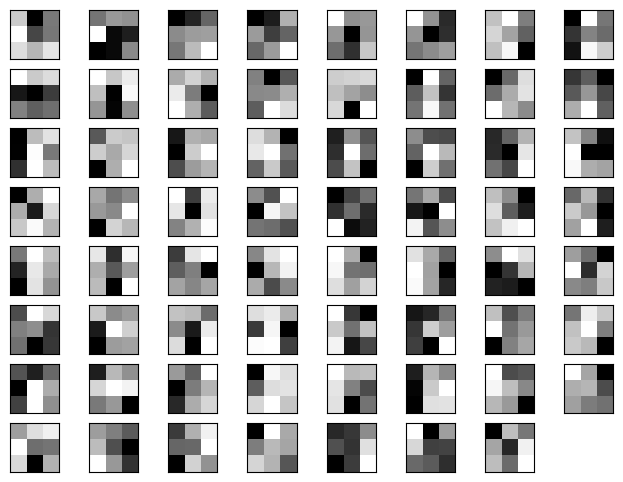

In [42]:
filters, biases = model.layers[4].get_weights()

fig1=plt.figure(figsize=(8,6))
columns=8
rows=8
n_filters = columns*rows

for i in range (1, n_filters):
  f = filters[:,:,:,i-1]
  fig1 = plt.subplot(rows,columns,i)
  fig1.set_xticks([])
  fig1.set_yticks([])
  plt.imshow(f[:,:,59], cmap='gray')

plt.show()